In [1]:
using Interpolations

INFO: Recompiling stale cache file /home/data/.julia/lib/v0.6/Interpolations.ji for module Interpolations.


In [2]:
using PyPlot, StatsBase, Dierckx

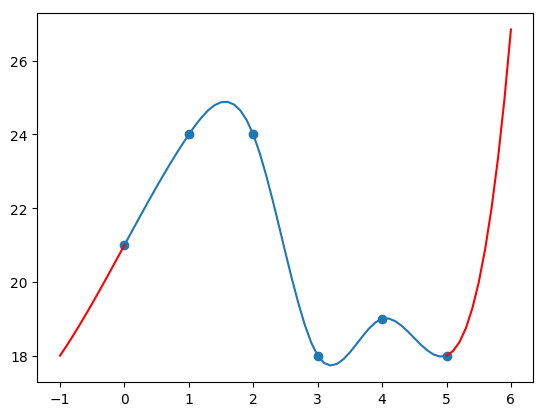

PyObject <matplotlib.collections.PathCollection object at 0x7fc707971b90>

In [3]:
Dx = #[-1.5, 0.2, 1., 5., 10., 15., 20.]
     [0.,   1,   2., 3., 4., 5.]   
Dy = #[-1.2, 0,   .5, 1., 1.2, 2.,  1.]
     [21.,  24., 24., 18., 19., 18.] 

S = interpolate((Dx,), Dy, Gridded(Cubic(Natural())))

interp_range = minimum(Dx):0.1:maximum(Dx)
plot(interp_range, S[interp_range])
extrap_range = (minimum(Dx)-1):0.1:minimum(Dx)
plot(extrap_range, S[extrap_range], color = "r")
extrap_range = maximum(Dx):0.1:maximum(Dx)+1
plot(extrap_range, S[extrap_range], color = "r")
scatter(Dx, Dy)

In [4]:
 S[interp_range]

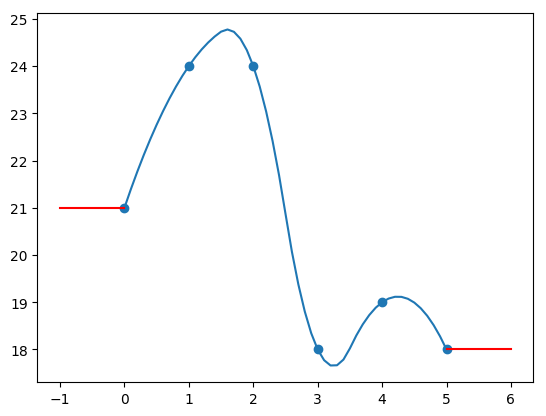

PyObject <matplotlib.collections.PathCollection object at 0x7f05875b0690>

In [4]:
figure()
S = Spline1D(Dx, Dy, k = 2)

interp_range = minimum(Dx):0.1:maximum(Dx)
plot(interp_range, S(interp_range))
extrap_range = (minimum(Dx)-1):0.1:minimum(Dx)
plot(extrap_range, S(extrap_range), color = "r")
extrap_range = maximum(Dx):0.1:maximum(Dx)+1
plot(extrap_range, S(extrap_range), color = "r")
scatter(Dx, Dy)

In [4]:
using BenchmarkTools

In [8]:
function interpolate(xvec::AbstractVector, a, b, c, d, X, v=false)
    # FIXME: this could be neater...
    idx = getidx(xvec[1],X)
    out = zeros(length(xvec))
    
    for x2 in xvec
        if x2 < X[idx+1]
            x = x2 - X[idx]
            interpolate(x, a, b, c, d, idx)
        else
            idx = getidx(x2,X)
            x2 - X[idx]
            interpolate(x, a, b, c, d, idx)
        end
    end
end

interpolate(x, a, b, c, d, idx) = a[idx]*(x^3) + b[idx]*(x^2) + c[idx]x + d[idx]

LoadError: [91merror in method definition: function Interpolations.interpolate must be explicitly imported to be extended[39m

In [ ]:
function getidx(x2,X)
    idx = max(searchsortedfirst(X,x2)-1,1)
    idx = min(idx, length(X)-1)
    return idx
end

In [5]:
Dy = rand(1000000)
Dx = collect(indices(Dy,1))


interp_range = minimum(Dx):0.1:maximum(Dx)
extrap_range = (minimum(Dx)-1):0.1:minimum(Dx)
extrap_range = maximum(Dx):0.1:maximum(Dx)+1

@time S = interpolate((Dx,), Dy, Gridded(Cubic(Natural())))

@time i  = S[interp_range]
@time e1 = S[extrap_range]
@time e2 = S[extrap_range]

@time S = Spline1D(Dx, Dy, k = 3)

@time i  = S(interp_range)
@time e1 = S(extrap_range)
@time e2 = S(extrap_range);

  0.100129 seconds (18 allocations: 61.036 MiB, 28.71% gc time)
  0.480082 seconds (25 allocations: 106.812 MiB, 20.50% gc time)
  0.015377 seconds (24 allocations: 30.519 MiB, 7.18% gc time)
  0.012648 seconds (24 allocations: 30.519 MiB, 8.08% gc time)
  0.250553 seconds (38 allocations: 194.552 MiB, 39.64% gc time)
  0.639131 seconds (18 allocations: 152.588 MiB, 15.79% gc time)
  0.000947 seconds (16 allocations: 784 bytes)
  0.000568 seconds (16 allocations: 784 bytes)


In [11]:
function get_derivatives(y)
    m = length(y) - 1
    γ = zeros(m+1) 
    δ = zeros(m+1)
    D = zeros(m+1)
    
    # forward substitution
    γ[1] = 0.5
    for i in 2:m
        γ[i] = 1/(4-γ[i-1])
    end
    γ[m+1] = 1/(2-γ[m])
        
    δ[1] = 3(y[2]-y[1])*γ[1]
    for i in 2:m
        δ[i] = (3(y[i+1] - y[i-1])-δ[i-1])*γ[i]
    end
    δ[m+1] = (3(y[m+1] - y[m]) - δ[m])*γ[m+1]
        
    # backward elimination
    D[m+1] = δ[m]
    for i in m:-1:1
        D[i] = δ[i] - γ[i]*D[i+1]
    end
        
    return D
end

function derivatives_to_coefs(D,y)
    a,b,c,d = [zeros(length(D)-1) for _ in 1:4]
    for i in 1:length(D)-1
        d[i] = y[i]
        c[i] = D[i]
        b[i] = 3(y[i+1]-y[i]) - 2D[i] - D[i+1]
        a[i] = 2(y[i]-y[i+1]) + D[i]  + D[i+1]
    end
    a,b,c,d
end

function coefficients(x,y)
    D       = get_derivatives(y)
    a,b,c,d = derivatives_to_coefs(D,y)
end

function interpolate2(x2, a, b, c, d, X, v=false)
    # FIXME: this could be neater...
    idx = max(searchsortedfirst(X,x2)-1,1)
    n   = length(X)
    idx = idx >= n ? idx - 1 : idx
    x   = x2 - X[idx]
    if idx < n
        return a[idx]*(x^3) + b[idx]*(x^2) + c[idx]x + d[idx]
    end
    error()
end

interpolate2 (generic function with 2 methods)

In [79]:
getidx(x, Dx) = max(searchsortedfirst(X,x)-1,1)

interpolate2(x, a, b, c, d, idx) = a[idx]*(x^3) + b[idx]*(x^2) + c[idx]*(x) + d[idx]


interpolate2 (generic function with 2 methods)

interpolate2 (generic function with 3 methods)

In [77]:
interpolate2.(interp_range2, [a], [b], [c], [d])

11-element Array{Array{Float64,1},1}:
 [21.0, 24.0, 24.0, 18.0, 19.0]               
 [21.322, 24.2471, 23.4967, 17.7992, 19.0074] 
 [21.6426, 24.4695, 22.8953, 17.7333, 18.9395]
 [21.9606, 24.656, 22.2246, 17.7768, 18.8154] 
 [22.2745, 24.7951, 21.5132, 17.904, 18.6546] 
 [22.5832, 24.8755, 20.79, 18.0897, 18.4764]  
 [22.8852, 24.8858, 20.0835, 18.3081, 18.3001]
 [23.1792, 24.8148, 19.4226, 18.5339, 18.1449]
 [23.4639, 24.6511, 18.8359, 18.7414, 18.0303]
 [23.7379, 24.3832, 18.3521, 18.9053, 17.9756]
 [24.0, 24.0, 18.0, 19.0, 18.0]               

In [ ]:
a,b,c,d = [Interpolations.coefficients(Dx,Dy)[n:4:end] for n in 1:4]
subplot(121)
    plot(interp_range, interpolate.(interp_range, [a], [b], [c], [d], [Dx]))
a1,b1,c1,d1 =  a,b,c,d
scatter(Dx,Dy)
    

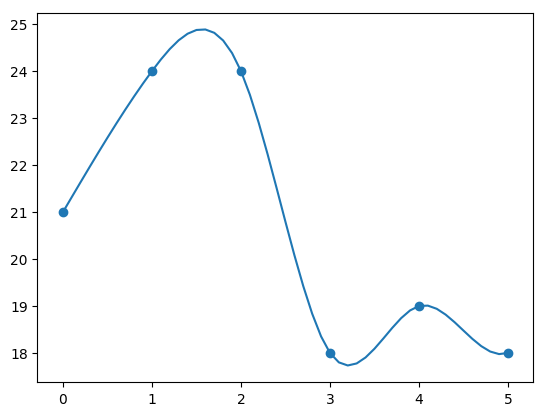

(a, b, c, d) = ([-0.221811, -1.89095, 4.78559, -4.25142, 3.22009], [0.0, -0.665433, -6.33827, 8.01851, -4.73575], [3.22181, 2.55638, -4.44732, -2.76709, 0.515666], [21.0, 24.0, 24.0, 18.0, 19.0])


PyObject <matplotlib.collections.PathCollection object at 0x7f7aa563bad0>

In [95]:
a,b,c,d = coefficients(Dx,Dy)
#subplot(122)
    plot(interp_range, interpolate2.(interp_range, [a], [b], [c], [d], [Dx]))
    @show a,b,c,d
    scatter(Dx,Dy)

In [43]:
[a a1; b b1; c c1; d d1]

20×2 Array{Float64,2}:
 -0.221811    -0.229665
 -1.89095     -1.85167 
  4.78559      4.63636 
 -4.25142     -3.69378 
  3.22009      1.13876 
  0.0          0.0     
 -0.665433     4.86603 
 -6.33827    -34.0622  
  8.01851     40.9091  
 -4.73575    -17.0813  
  3.22181      3.22967 
  2.55638     -1.63636 
 -4.44732     76.2201  
 -2.76709   -148.694   
  0.515666    83.2679  
 21.0         21.0     
 24.0         22.622   
 24.0        -29.2823  
 18.0        195.632   
 19.0       -113.651   

In [2]:
Dy = rand(1000)
Dx = collect(indices(Dy,1))

interp_range = minimum(Dx):0.1:maximum(Dx)
extrap_range = (minimum(Dx)-1):0.1:minimum(Dx)
extrap_range = maximum(Dx):0.1:maximum(Dx)+1

1000.0:0.1:1001.0

In [19]:
@time S = interpolate((Dx,), Dy, Gridded(Cubic(Natural())))

@time i  = S[interp_range]

  0.000163 seconds (124 allocations: 21.344 KiB)
  0.000019 seconds (25 allocations: 2.531 KiB)


91-element Array{Float64,1}:
  32.5163
  37.8876
  44.0579
  51.0879
  59.0385
  67.9705
  77.9447
  89.022 
 101.263 
 114.729 
 129.48  
 105.307 
 121.666 
   ⋮     
 759.366 
 787.626 
  48.3534
  50.1686
  52.0269
  53.9287
  55.8746
  57.8651
  59.9006
  61.9817
  64.1088
  66.2824

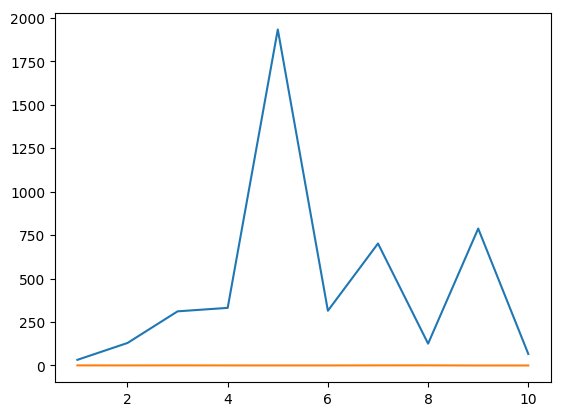

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa8caf95510>

In [65]:
a,b,c,d = [Interpolations.coefficients(Dx, Dy)[n:4:end] for n in 1:4]
plot(Dx, interpolate.(Dx, [a], [b], [c], [d], [Dx]))
    plot(Dx, Dy)

In [ ]:
a,b,c,d 

In [ ]:
a1,b1,c1,d1 = [Interpolations.coefficients(Dx, Dy)[n:4:end] for n in 1:4]

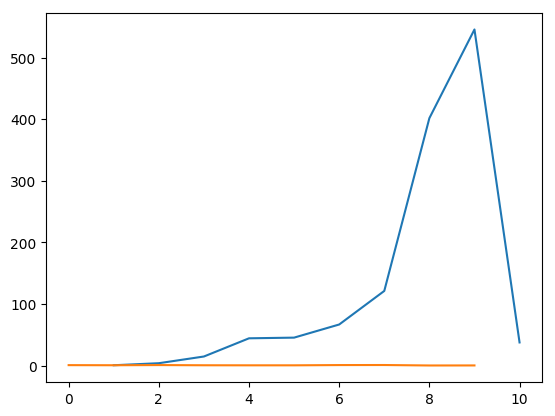

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa8cb11a310>

In [61]:
plot(Dy)

In [17]:
x = Interpolations.spline_coef_equations(Dx, Dy)[1]
x[x.==0] .= NaN;

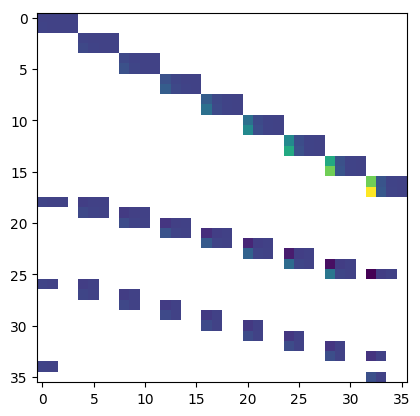

PyObject <matplotlib.image.AxesImage object at 0x7fa8cb43b290>

In [18]:
imshow(x)

  2.491110 seconds (210.82 k allocations: 497.879 MiB, 3.11% gc time)
  0.001353 seconds (26 allocations: 220.297 KiB)
  0.000017 seconds (26 allocations: 64.250 KiB)
  0.000016 seconds (26 allocations: 64.250 KiB)
  0.188332 seconds (106.53 k allocations: 5.838 MiB)
  0.040564 seconds (14.14 k allocations: 1.033 MiB)
  0.000005 seconds (16 allocations: 784 bytes)
  0.000004 seconds (16 allocations: 784 bytes)


In [8]:
Dy = rand(2000)
Dx = collect(indices(Dy,1))


interp_range = minimum(Dx):0.1:maximum(Dx)
extrap_range = (minimum(Dx)-1):0.1:minimum(Dx)
extrap_range = maximum(Dx):0.1:maximum(Dx)+1

@time S = interpolate((Dx,), Dy, Gridded(Cubic(Natural())))

@time i  = S[interp_range]
@time e1 = S[extrap_range]
@time e2 = S[extrap_range]

@time S = Spline1D(Dx, Dy, k = 3)

@time i  = S(interp_range)
@time e1 = S(extrap_range)
@time e2 = S(extrap_range);

 13.116532 seconds (33.65 k allocations: 977.610 MiB, 1.81% gc time)
  0.001441 seconds (26 allocations: 220.297 KiB)
  0.000050 seconds (25 allocations: 64.203 KiB)
  0.000038 seconds (25 allocations: 64.203 KiB)
  0.000425 seconds (32 allocations: 400.719 KiB)
  0.001143 seconds (18 allocations: 312.953 KiB)
  0.000009 seconds (16 allocations: 784 bytes)
  0.000005 seconds (16 allocations: 784 bytes)


In [9]:
Profile.print()

4388 ./task.jl:335; (::IJulia.##14#17)()
 4388 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  4388 ...rc/execute_request.jl:154; execute_request(::ZMQ.Socket, ::...
   4388 ...Compat/src/Compat.jl:464; include_string(::Module, ::Stri...
    4388 ./loading.jl:515; include_string(::String, ::String)
     4388 ./<missing>:?; anonymous
      4388 ./profile.jl:23; macro expansion
       202  ./inference.jl:2603; typeinf_ext(::Core.MethodIns...
        202 ./inference.jl:2564; typeinf_code(::Core.MethodIn...
         202 ./inference.jl:2494; typeinf_frame(::Core.Method...
          202 ./inference.jl:2641; typeinf_loop(::Core.Inferen...
           202 ./inference.jl:2778; typeinf_frame(::Core.Infer...
            202 ./inference.jl:1935; abstract_eval(::Any, ::Arr...
             202 ./inference.jl:1912; abstract_eval_call(::Expr...
              202 ./inference.jl:1882; abstract_call(::Any, ::A...
               202 ./inference.jl:1401; abstract_call_gf_by_type...
                20

                                    +66 82 ...nce.jl:1935; abstract_...
                                    +67 82 ...nce.jl:1912; abstract_...
                                    +68 82 ...nce.jl:1882; abstract_...
                                    +69 1  ...nce.jl:1282; abstract_...
                                    +70 1 ...tion.jl:521; _methods_by...
                                    +69 81 ...nce.jl:1401; abstract_...
                                    +70 81 ...nce.jl:2517; typeinf_e...
                                    +71 81 ...nce.jl:2494; typeinf_f...
                                    +72 81 ...nce.jl:2624; typeinf_l...
                                    +73 81 ...nce.jl:2778; typeinf_f...
                                    +74 81 ...nce.jl:1935; abstract_...
                                    +75 81 ...nce.jl:1912; abstract_...
                                    +76 81 ...nce.jl:1882; abstract_...
                                    +77 81 ...nce.jl:1401; abst

                                    +96 1 ...nce.jl:4107; inlineable...
                                    +97 1 ...nce.jl:3336; substitute...
                                    +98 1 ...nce.jl:3336; substitute...
                                    +99 1 ...nce.jl:3336; substitute...
                                   +100 1 ...nce.jl:3336; substitute...
                                   +101 1 ...nce.jl:3296; substitute...
                                    +94 3 ...nce.jl:4492; inlining_p...
                                    +95 1 ...nce.jl:3782; inlineable...
                                    +95 1 ...nce.jl:3922; inlineable...
                                    +96 1 ...nce.jl:3528; inline_as_...
                                    +97 1 ...nce.jl:3494; effect_fre...
                                    +98 1 ...nce.jl:3494; effect_fre...
                                    +99 1 ...nce.jl:3494; effect_fre...
                                   +100 1 ...nce.jl:3446; effect

                                    +21 1 ...nce.jl:1223; (::Core.In...
                                    +15 1   ...ce.jl:2749; typeinf_f...
                                    +16 1 ...nce.jl:1935; abstract_e...
                                    +17 1 ...nce.jl:1912; abstract_e...
                                    +18 1 ...nce.jl:1859; abstract_c...
                                    +19 1 ...ence.jl:335; istopfuncti...
                                    +20 1 ...tion.jl:170; isconst
                                    +15 89  ...ce.jl:2854; typeinf_f...
                                    +16 17 ...nce.jl:2955; optimize(...
                                    +17 17 ...nce.jl:4329; inlining_...
                                    +18 14 ...nce.jl:4391; inlining_...
                                    +19 5 ...nce.jl:4391; inlining_p...
                                    +20 1 ...nce.jl:4391; inlining_p...
                                    +21 1 ...nce.jl:4492; inlining_p.

                                    +16 1  ...nce.jl:2969; optimize(...
                                    +17 1 ...nce.jl:3261; widen_all_...
                                    +18 1 ...nce.jl:3246; _widen_all...
                                    +19 1 ...nce.jl:3246; _widen_all...
                                    +20 1 ...nce.jl:3244; _widen_all...
                                    +15 1   ...ce.jl:2855; typeinf_f...
                                    +16 1 ...nce.jl:3072; finish(::C...
                                     +6 1   ...ce.jl:2854; typeinf_f...
                                     +7 1 ...nce.jl:2955; optimize(:...
                                     +8 1 ...nce.jl:4329; inlining_p...
                                     +9 1 ...nce.jl:4391; inlining_p...
                                    +10 1 ...nce.jl:4450; inlining_p...
                           3   ./inference.jl:2854; typeinf_frame(::C...
                            2 ./inference.jl:2955; optimize(::C

In [27]:
function GriddedInterpolation(::Type{TWeights}, knots::NTuple{N,GridIndex}, A::AbstractArray{TCoefs,N}, ::IT, ::Val{pad}) where {N,TCoefs,TWeights<:Real,IT<:DimSpec{Gridded},pad}
    isleaftype(IT) || error("The b-spline type must be a leaf type (was $IT)")
    isleaftype(TCoefs) || warn("For performance reasons, consider using an array of a concrete type (eltype(A) == $(eltype(A)))")

    knts = mapcollect(knots...)
    for (d,k) in enumerate(knts)
        length(k) == size(A, d) || throw(DimensionMismatch("knot vectors must have the same number of elements as the corresponding dimension of the array"))
        length(k) == 1 && error("dimensions of length 1 not yet supported")  # FIXME
        issorted(k) || error("knot-vectors must be sorted in increasing order")
        iextract(IT, d) != NoInterp || k == collect(1:size(A, d)) || error("knot-vector should be the range 1:$(size(A,d)) for the method Gridded{NoInterp}")
    end
    c = zero(TWeights)
    for _ in 2:N
        c *= c
    end
    T = Core.Inference.return_type(*, Tuple{typeof(c), TCoefs})

    GriddedInterpolation{T,N,TCoefs,IT,typeof(knts),pad}(knts, A)
end


LoadError: [91mMethodError: no method matching Interpolations.Degree()[39m

In [22]:
@time S = interpolate((Dx,), Dy, Gridded(Cubic(Natural())))

@profile i  = S[interp_range]
Profile.print()

  0.000120 seconds (9 allocations: 8.188 KiB)
1634 ./task.jl:335; (::IJulia.##14#17)()
 1634 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  1634 ...rc/execute_request.jl:154; execute_request(::ZMQ.Socket, ::...
   1634 ...Compat/src/Compat.jl:464; include_string(::Module, ::Stri...
    1634 ./loading.jl:515; include_string(::String, ::String)
     1634 ./<missing>:?; anonymous
      1634 ./profile.jl:23; macro expansion
       1632 ...rc/gridded/cubic.jl:7; getindex(::Interpolations.Grid...
        652 ...rc/gridded/cubic.jl:50; #coefficients#55(::Bool, ::Sy...
         652 ./<missing>:0; (::Interpolations.#kw##spline...
          647 ...c/gridded/cubic.jl:67; #spline_coef_equations#58(:...
           137 ./array.jl:227; fill!(::Array{Float64,2}, :...
          1   ...c/gridded/cubic.jl:68; #spline_coef_equations#58(:...
          1   ...c/gridded/cubic.jl:89; #spline_coef_equations#58(:...
           1 ./broadcast.jl:204; broadcast!
            1 ./broadcast.jl:211; broadcast_

In [10]:
length(interp_range)

41

In [ ]:
itp = S

for boundary_condition in [:natural, :periodic, :notaknot, :quadratic]
    try
        x = collect(0:0.1:4.)
        a,b,c = coefficient3s(itp.knots[1], itp.coefs,
        boundary_condition = boundary_condition,
            force_linear_extrapolation=false)
        Dy2 = interpolate.(x, [a], [b], [c], [itp.knots[1]], [itp.coefs]);
        plot(x,Dy2, label = boundary_condition)
    end
end

legend()
scatter(Dx, Dy)

In [400]:
function interpolate(a, b, c, d, x, X, v=false)
    idx = max(searchsortedfirst(X,x)-1,1)
    n   = length(X)
    idx = idx >= n ? idx - 1 : idx
    if idx < n                    # interpolation
        return a[idx]*(x^3) + b[idx]*(x^2) + c[idx]x + d[idx]
    end
    error()
end

interpolate (generic function with 5 methods)

In [ ]:
function expand_array!(x2t, x2)
    x2t[1]       = x2[1]
    x2t[end]     = x2[end]
    x2t[2:end-1] = cat(2, x2[2:end-1], x2[2:end-1])'[:]
    x2t
end

function expand_array2!(rhs, y)
    n = length(y)
    rhs[1] = y[1]        # f₀(1) = y[1] 
    for i in 2:(n-1)
        k = 2(i-1)       # fᵢ    = y[i]
        rhs[k]   = y[i]  # fᵢ₊₁  = y[i] 
        rhs[k+1] = y[i]
    end
    rhs[n] = y[n] # fₙ    = y[n]
end

function expand_array(x2::AbstractArray{T,1}) where T
    x2t = zeros(T,2(size(x2,1)-1))
    expand_array!(x2t, x2)
end

function spline_coefs(x, y;
        force_linear_extrapolation = true,
        boundary_condition = :natural)
    A,rhs = spline_coefs_tosolve(x, y, force_linear_extrapolation=force_linear_extrapolation,
        boundary_condition=boundary_condition)
    coefficients = A\rhs
    a,b,c,d = [coefficients[n:4:end] for n in 1:4]
    return a,b,c,d
end

function spline_coefs_tosolve(x, y;
        force_linear_extrapolation = true,
        boundary_condition = :natural
    )
    valid_boundary_conditions = [:natural, :periodic, :notaknot, :quadratic]
    if !(boundary_condition in valid_boundary_conditions)
        error("Boundary Condition must be one of $valid_boundary_conditions not $boundary_condition")
    end

    n   = length(x)
    n2  = (n-1)^2
    A   = zeros(4(n-1),4(n-1))
    rhs = zeros(4(n-1))
    
    # First 2(n-1) polynomials are of the form:
    #     fᵢ = aᵢx³ + bᵢx² +cᵢx + dᵢ
    rhs[1:2(n-1)] = expand_array(y)

    x2     = expand_array(x)
    x2inds = expand_array(1:length(x))
    niind = 0
    for xi in 1:(length(x2))
        for ni in 1:4
            A[xi, (niind+ni)] = x2[xi]^(4-ni)
        end
        iseven(xi) && (niind += 4 )
    end


    # Next polynomials from first derivative
    #    3ax² + 2bx + c + 0
    niind = 1
    for xi in 2:(n-1)
        rind = xi + 2(n-1) - 1
        A[rind,niind:niind+3] .= A[rind,(niind+4):(niind+7)] .= [(3*(x[xi]^2)),2x[xi],1,0]
        A[rind,niind+4:niind+7] *= -1.
        niind += 4
    end
    
    # Next polynomials from 2nd derivative
    #    6ax + 2b + 0 + 0
    niind = 1
    for xi in 2:(n-1)
        rind = xi + 2(n-1) + n - 3
        A[rind,niind:niind+3] .= A[rind,(niind+4):(niind+7)] .= [6*(x[xi]),2,0,0]
        A[rind,niind+4:niind+7] *= -1.
        niind += 4
    end
    
    # Next boundary conditions:
    # Natural Spline Satisfies:
    # 6a₁x₁   + 2b₁ = 0
    A[end-1,1] = 6x[1]
    A[end-1,2] = 2.
    # 6aₙxₙ₊₁ + 2bₙ = 0
    A[end,4(n-2)+1]  = 6x[end]
    A[end,4(n-2)+2]  = 2.
    
    return A,rhs
end

In [ ]:
A,rhs = spline_coefs_tosolve(Dx, Dy)
A\rhs

In [ ]:
N = 15

Dx = collect(1:1.:N)
Dy = rand(N)

interpolate(coefs, x, X) = interpolate(coefs..., x, X)
coefs = spline_coefs(Dx, Dy)

x_t = collect(-2:0.1:N+2)
out = interpolate.([coefs], x_t, [Dx])

plot(x_t, out)
scatter(Dx,Dy)

In [ ]:
function coefficient3s(x, y;
        force_linear_extrapolation = true,
        boundary_condition = :natural
    )
    valid_boundary_conditions = [:natural, :periodic, :notaknot, :quadratic]
    if !(boundary_condition in valid_boundary_conditions)
        error("Boundary Condition must be one of $valid_boundary_conditions not $boundary_condition")
    end
    
    const x1   = 0.
    const xend = 0.

    n   = length(x)
    A   = zeros(n,n)
    rx  = zeros(n)
    for i in 2:(n-1)
        A[i-1,i]  = 1.0/3.0*(x[i]-x[i-1]);
        A[i,i]    = 2.0/3.0*(x[i+1]-x[i-1]);
        A[i+1,i]  = 1.0/3.0*(x[i+1]-x[i]);
        rx[i]  = (y[i+1]-y[i])/(x[i+1]-x[i]) - (y[i]-y[i-1])/(x[i]-x[i-1])
    end
        
    if boundary_condition == :natural
        A[1,1] = 6.0
        A[2,1] = 2.0
        rx[1] = x1

        A[n,n] = 6.0
        A[n-1,n] = 2.0
        rx[n] = xend
    elseif boundary_condition == :periodic
        A[1,1] = 2.0*(x[2]-x[1])
        A[2,1] = 1.0*(x[2]-x[1])
        rx[1]  = 3.0*((y[2]-y[1])/(x[2]-x[1])-x1)

        A[n,n]   = 2.0*(x[n]-x[n-1])
        A[n-1,n] = 1.0*(x[n]-x[n-1])
        rx[n]    = 3.0*(0-(y[n]-y[n-1])/(x[n]-x[n-1]))
    elseif boundary_condition == :notanot
        A[1,1] = A[1,2]
        A[n,n-1] = A[n,n]
    elseif boundary_condition == :quadratic
        A[1,1] = 1.
        A[n,n] = 1.
    end
    
    display(A)
    display(rx)
    
    b = A \ rx;

    a = zeros(n)
    c = zeros(n)
    for i in 1:(n-1)
        a[i]=1.0/3.0*(b[i+1]-b[i])/(x[i+1]-x[i])
        c[i]=(y[i+1]-y[i])/(x[i+1]-x[i])- 1.0/3.0*(2.0*b[i]+b[i+1])*(x[i+1]-x[i])
    end

    if force_linear_extrapolation
        b[1]   = 0.0
        b[n]   = 0.0
        a[n]   = 0.0
        h      = x[n]-x[n-1];
        c[n]   = 3a[n-1] * (h * h)  +  2b[n-1] * h  +  c[n-1]
    end

    return a, b, c
end


In [ ]:
figure(figsize=(10,2))
A_real = sin.(linspace(1,20,10500))
knots = (sort(unique(sample(1:10000,40,replace=false))),)
A = A_real[knots[1]]

points_to_interp = -1000:1:11000
s1 = interpolate(knots, A, Gridded(Cubic(Reflect())))
title("Cubic Interpolation", size = 10)
plot(points_to_interp,s1[points_to_interp])
scatter(knots[1], A, marker="x")

In [ ]:
A_real = sin.(linspace(1,20,10000))
knots = (sort(unique(sample(1:10000,40,replace=false))),)
A = A_real[knots[1]]

figure(figsize=(4,4))
subplot(2,2,1)
title("Ground Truth", size=10)
scatter(knots[1], A, marker="x")
plot(A_real)


subplot(2,2,2)
s1 = interpolate(knots, A, Gridded(Linear()))
title("Linear Interpolation", size = 10)
plot(1:1:10000,s1[1:1:10000])
scatter(knots[1], A, marker="x")

subplot(2,2,3)
s1 = interpolate(knots, A, Gridded(Cubic(Reflect())))
title("Cubic Interpolation", size = 10)
plot(1:1:10000,s1[1:1:10000])
scatter(knots[1], A, marker="x")

tight_layout()

In [ ]:


function interp(x, m_a, m_b, m_c, m_x, m_y, v=false)
    it  = searchsortedfirst(m_x,x)
    idx = max(it-1,1)
    h   = x - m_x[idx];
    
    if (x < m_x[1]) # extrapolation to the left
        v && println("extrap back")
        interpol=(m_b0*h + m_c0)*h + m_y[1];
    elseif (x>m_x[n])# extrapolation to the right
        v && println("extrap fwd")
        interpol=(m_b[n-1]*h + m_c[n])*h + m_y[n-1];
    else # interpolation
        v && println("interp $it $idx $h")
        interpol=((m_a[idx]*h + m_b[idx])*h + m_c[idx])*h + m_y[idx];
    end
    interpol
end

interp(s::CubicSpline, x) = interp(x, s.a, s.b, s.c, s.x, s.y)

mutable struct CubicSpline
    a
    b
    c
    x
    y
    opts::Any
end

"""
fit_spline(x, y;
    m_left_value = 0.
    m_right_value = 0.
    m_force_linear_extrapolation = true
    m_left,m_right = :first_deriv,:first_deriv
)
"""
function fit_spline(x, y;
    m_left_value = 0.
    m_right_value = 0.
    m_force_linear_extrapolation = true
    m_left,m_right = :first_deriv,:first_deriv
    )
    
    m_a, m_b, m_c = get_all_coefs(x, y, m_left_value, m_right_value, m_force_linear_extrapolation, 
m_left,m_right)
    
    CubicSpline(m_a, m_b, m_c, x, y, (m_left_value, m_right_value, m_force_linear_extrapolation, 
m_left,m_right))
end


function get_all_coefs(x, y, m_left_value, m_right_value, m_force_linear_extrapolation, 
m_left,m_right)  
    n   = length(x)
    A   = zeros(n,n)
    rhs = zeros(n)
    for i in 2:(n-1)
        A[i-1,i]  = 1.0/3.0*(x[i]-x[i-1]);
        A[i,i]    = 2.0/3.0*(x[i+1]-x[i-1]);
        A[i+1,i]  = 1.0/3.0*(x[i+1]-x[i]);
        rhs[i]  = (y[i+1]-y[i])/(x[i+1]-x[i]) - (y[i]-y[i-1])/(x[i]-x[i-1])
    end
    
    A[1,1] = 2.0;
    A[2,1] = 0.0;
    rhs[1] = m_left_value;

    A[n,n]   = 2.0;
    A[n-1,n] = 0.0;
    rhs[n]   = m_right_value;

    if (m_left == :second_deriv)
        A[1,1] = 2.0;
        A[2,1] = 0.0;
        rhs[0] = m_left_value;
    elseif (m_left == :first_deriv)
        A[1,1] = 2.0*(x[2]-x[1]);
        A[2,1] = 1.0*(x[2]-x[1]);
        rhs[1] = 3.0*((y[2]-y[1])/(x[2]-x[1])-m_left_value);
    else
        assert(false);
    end
    
    if (m_right == :second_deriv)
    A[n,n] = 2.0;
    A[n-1,n] = 0.0;
    rhs[n] = m_right_value;
    elseif (m_right == :first_deriv)
        A[n,n] = 2.0*(x[n]-x[n-1]);
        A[n-1,n] =1.0*(x[n]-x[n-1]);
        rhs[n]=3.0*(m_right_value-(y[n]-y[n-1])/(x[n]-x[n-1]));
    end

    m_b = A \ rhs;

    m_a = zeros(n)
    m_c = zeros(n)
    for i in 1:(n-1)
        m_a[i]=1.0/3.0*(m_b[i+1]-m_b[i])/(x[i+1]-x[i])
        m_c[i]=(y[i+1]-y[i])/(x[i+1]-x[i])- 1.0/3.0*(2.0*m_b[i]+m_b[i+1])*(x[i+1]-x[i])
    end

    m_b0   = (m_force_linear_extrapolation==false) ? m_b[1] : 0.0;
    m_c0   = m_c[1];
    h      = x[n]-x[n-1];
    m_a[n] = 0.0;
    m_c[n] = 3.0*m_a[n-1]*h*h+2.0*m_b[n-1]*h+m_c[n-1]
    m_force_linear_extrapolation && (m_b[n]=0.0)
    return m_a, m_b, m_c
end

In [ ]:
using StatsBase

In [ ]:
Y = rand(100)
x = sort(unique(sample(1:100,100,replace=false)))
y = Y[x];

In [ ]:
figure(figsize=(6,3))
title("Ground Truth")

subplot(1,2,1)
scatter(x,y)
plot(Y)

subplot(1,2,2)
s1 = fit_spline(x,y)
title("Interpolation")
plot(1:1:100,interp.(s1,collect(1:1:100)))
scatter(x,y)

In [ ]:
import Base.getindex

In [ ]:






m_x = copy(x);
m_y = copy(y);

In [ ]:
interp.(1:100:1000, true)

In [ ]:
using PyPlot
figure(figsize=(3,3))
scatter(x,y)
inds = -1000:maximum(x)
plot(inds,interp.(inds),color="k")

In [ ]:
x

In [ ]:
idx = 20
order = 1

function deriv(order, x)
    it = min(m_x[1],m_x[end],x)
    idx = max(it-m_x[1]-1,1)
    
    h= x - m_x[idx];
    if x < m_x[1] # extrapolation to the left
        if order == 1
            interpol=2.0*m_b0*h + m_c0;
        elseif order == 2
            interpol=2.0*m_b0*h;
        else
            interpol=0.0;
        end
    elseif x > m_x[n-1] # extrapolation to the right
        if order == 1
            interpol = 2.0*m_b[n]*h + m_c[n];
        elseif order == 2
            interpol = 2.0*m_b[n];
        else
            interpol = 0.0;
        end
    else # interpolation
        if order == 1
            interpol = (3.0*m_a[idx]*h + 2.0*m_b[idx])*h + m_c[idx];
        elseif order == 2
            interpol = 6.0*m_a[idx]*h + 2.0*m_b[idx];
        elseif order == 3
            interpol = 6.0*m_a[idx];
        else
            interpol = 0.0;
        end
    end
    interpol
end